In [1]:
import pandas as pd
import numpy as np
import os
import sys

# !pip install librosa
# !pip install lifelines
# !pip install np_utils
# !pip install tensorflow

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt


import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

C:\Users\josha\AppData\Local\Temp\ipykernel_11692\1064882521.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Importing and Splitting the datasets

In [2]:
#importing the datasets
train_set = pd.read_csv('outputs/fer_train_set_ov2_no_mismatch.csv')
test_set = pd.read_csv('outputs/fer_test_set_ov2_no_mismatch.csv')

In [3]:
#Split into features and target; x = features, y = target
x_train = train_set.iloc[:, 1:]
y_train = train_set['label']

x_test = test_set.iloc[:, 1:]
y_test = test_set['label']

#combining test and train set for cross validation
x = pd.concat([x_train, x_test])
y = pd.concat([y_train, y_test])

In [4]:
x_test

,lm_1_x,lm_1_y,lm_1_z,lm_2_x,lm_2_y,lm_2_z,lm_3_x,lm_3_y,lm_3_z,lm_4_x,...,lm_475_z,lm_476_x,lm_476_y,lm_476_z,lm_477_x,lm_477_y,lm_477_z,lm_478_x,lm_478_y,lm_478_z
0,0.582506,0.697162,-0.067077,0.592679,0.618078,-0.103991,0.589574,0.645011,-0.060301,0.572942,...,0.030444,0.635687,0.428783,0.030438,0.617177,0.441305,0.030421,0.638939,0.454816,0.030424
1,0.587971,0.694053,-0.060515,0.606342,0.624488,-0.103724,0.598081,0.645070,-0.058398,0.585974,...,0.028123,0.722144,0.495633,0.028121,0.699625,0.510474,0.028099,0.718919,0.530328,0.028104
2,0.589091,0.694982,-0.061337,0.607350,0.620015,-0.101784,0.600376,0.645693,-0.057030,0.586683,...,0.034687,0.477167,0.346113,0.034685,0.457734,0.362176,0.034668,0.481573,0.379474,0.034673
3,0.586884,0.692392,-0.061881,0.610403,0.614323,-0.112607,0.603356,0.639406,-0.060215,0.604628,...,0.027755,0.767338,0.487988,0.027749,0.745520,0.499784,0.027732,0.759628,0.519441,0.027734
4,0.575416,0.696893,-0.065459,0.591004,0.609352,-0.105787,0.585565,0.641095,-0.059474,0.576083,...,0.037065,0.652672,0.373902,0.037054,0.632773,0.387560,0.037043,0.654505,0.403471,0.037047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413,0.588003,0.696004,-0.059679,0.603343,0.613309,-0.106070,0.597838,0.642411,-0.056019,0.581076,...,0.005553,0.643143,0.342731,0.005547,0.623186,0.357389,0.005533,0.647402,0.371337,0.005536
1414,0.167516,0.220187,-0.046459,0.168308,0.164029,-0.071845,0.168068,0.182306,-0.041768,0.151808,...,0.020130,0.221689,0.079219,0.020129,0.207401,0.091495,0.020115,0.223186,0.103090,0.020118
1415,0.582201,0.693010,-0.064271,0.597639,0.625183,-0.106025,0.591793,0.646426,-0.060419,0.582833,...,0.028148,0.725002,0.518884,0.028146,0.703697,0.530414,0.028125,0.719072,0.549746,0.028128
1416,0.581071,0.696840,-0.058943,0.609299,0.614386,-0.111071,0.600144,0.639634,-0.057607,0.598876,...,0.025536,0.740494,0.477317,0.025527,0.722033,0.488151,0.025510,0.734822,0.505383,0.025514


In [5]:
y_test

0           sad
1         happy
2         happy
3       neutral
4       neutral
         ...   
1413      happy
1414      happy
1415        sad
1416      happy
1417        sad
Name: label, Length: 1418, dtype: object

In [6]:
import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

#Get the labels
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
y_test = encoder.fit_transform(np.array(y_test).reshape(-1,1)).toarray()

y_test

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]])

In [7]:
scaler = StandardScaler()
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
# x_train.shape, y_train.shape, x_test.shape, y_test.shape

#x_train = np.expand_dims(x_train, axis=2)
#x_test = np.expand_dims(x_test, axis=2)
# x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [8]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5674, 1434), (5674, 4), (1418, 1434), (1418, 4))

In [9]:
model= Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=4, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1434, 256)         1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 717, 256)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 717, 256)          327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 359, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 359, 256)          327936    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 180, 256)        

In [11]:
checkpoint_filepath = os.getcwd() + '/fer_ckpt_cnn/Epoch{epoch:02d}_{accuracy:.2f}.keras'
checkpoint_filepath

'c:\\Users\\josha\\OneDrive\\Documents\\SCHOOL\\College\\AFFECTV-XX22-Project\\Data Cleaning & Model Training/fer_ckpt_cnn/Epoch{epoch:02d}_{accuracy:.2f}.keras'

In [12]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='accuracy',
    mode='max')

In [13]:
rlrp = ReduceLROnPlateau(monitor='accuracy', factor=0.8, verbose=1, patience=2, min_lr=0.0001)
history = model.fit(x_train, y_train, batch_size=64, epochs=30, validation_data=(x_test, y_test), callbacks=[rlrp, model_checkpoint_callback])

Epoch 1/30


89/89 [==============================] - 99s 1s/step - loss: 1.3844 - accuracy: 0.2850 - val_loss: 1.4377 - val_accuracy: 0.1016 - lr: 0.0010
Epoch 2/30
89/89 [==============================] - 103s 1s/step - loss: 1.3805 - accuracy: 0.2793 - val_loss: 1.4537 - val_accuracy: 0.1016 - lr: 0.0010
Epoch 3/30
89/89 [==============================] - ETA: 0s - loss: 1.3803 - accuracy: 0.2753
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
89/89 [==============================] - 102s 1s/step - loss: 1.3803 - accuracy: 0.2753 - val_loss: 1.4342 - val_accuracy: 0.2094 - lr: 0.0010
Epoch 4/30
89/89 [==============================] - 97s 1s/step - loss: 1.3796 - accuracy: 0.2820 - val_loss: 1.4436 - val_accuracy: 0.1016 - lr: 8.0000e-04
Epoch 5/30
89/89 [==============================] - ETA: 0s - loss: 1.3785 - accuracy: 0.2804
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.
89/89 [==============================] - 94s 1s/step

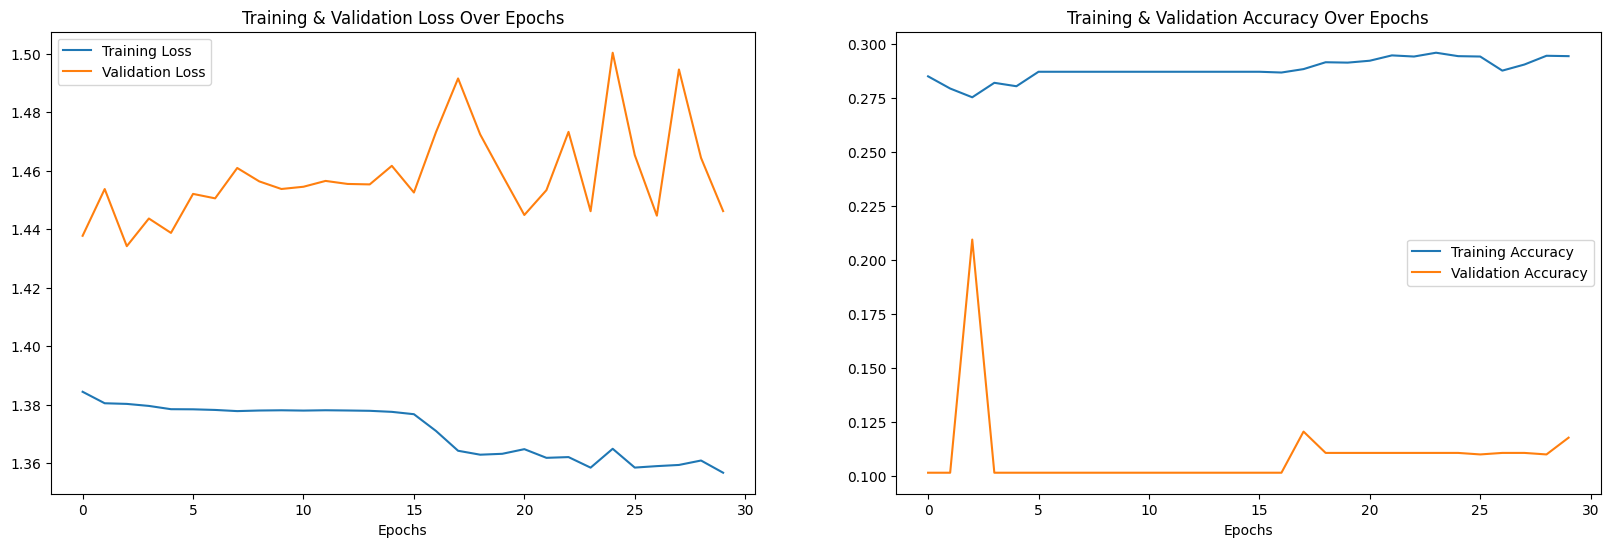

In [14]:
epochs = [i for i in range(30)]
fig, ax = plt.subplots(1,2)
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']
test_accuracy = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs, train_loss, label = 'Training Loss')
ax[0].plot(epochs, test_loss, label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss Over Epochs')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, train_accuracy, label = 'Training Accuracy')
ax[1].plot(epochs, test_accuracy, label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy Over Epochs')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [15]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

45/45 [==============================] - 6s 123ms/step


In [15]:
y_pred

array([['happy'],
       ['anger'],
       ['happy'],
       ...,
       ['anger'],
       ['anger'],
       ['happy']], dtype=object)

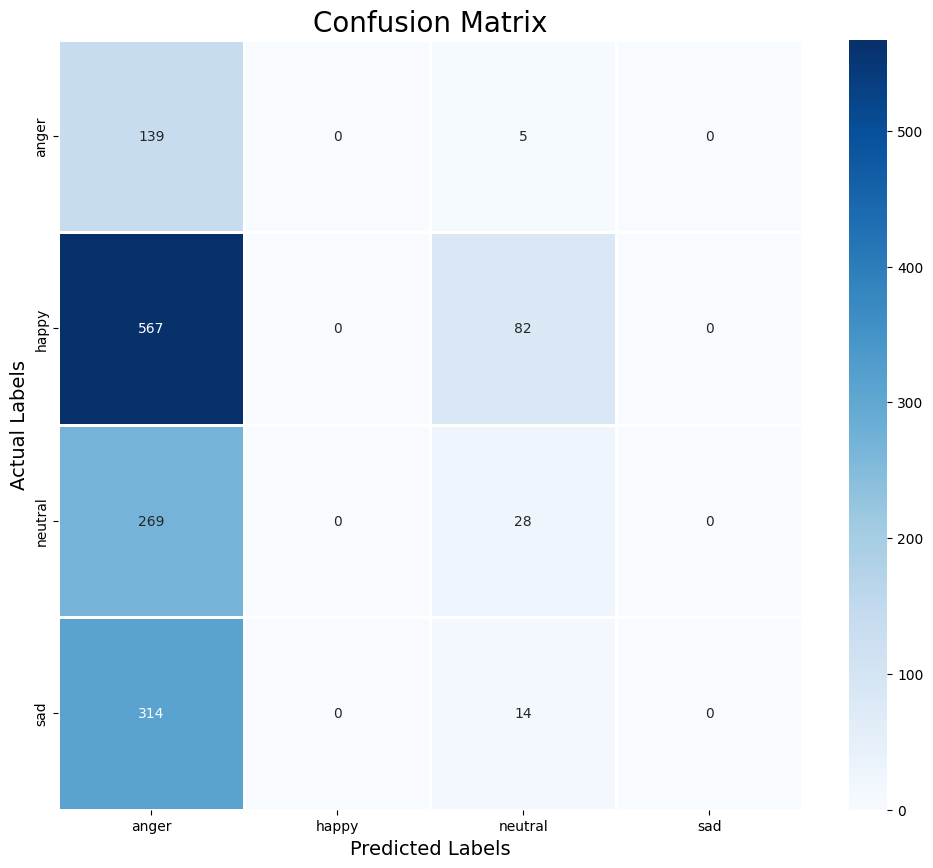

In [16]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

acs_test = accuracy_score(y_test,y_pred)
ps_test = precision_score(y_test,y_pred, average = "macro")
rs_test = recall_score(y_test,y_pred,  average = "macro")
fs_test = f1_score(y_test,y_pred,  average = "macro")

print("Accuracy Score: ", "{:.2%}".format(acs_test))
print("Precision Score: ", "{:.2%}".format(ps_test))
print("Recall Score: ", "{:.2%}".format(rs_test))
print("F1 Score: ", "{:.2%}".format(fs_test))

Accuracy Score:  77.05%
Precision Score:  64.45%
Recall Score:  65.00%
F1 Score:  64.36%
